In [74]:
# mounting Google Drive in your VM
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [75]:
# installing requirements
!pip install tensorflow
!pip install matplotlib
!pip install numpy

In [76]:
# importing modules
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [77]:
# constans:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 60

In [78]:
# images from hard disk to batches
dataset_potato = tf.keras.preprocessing.image_dataset_from_directory(
    "/gdrive/MyDrive/hackaton/dataset_potato",
    shuffle=True,
    image_size = (IMAGE_SIZE, BATCH_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [79]:
class_names = dataset_potato.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

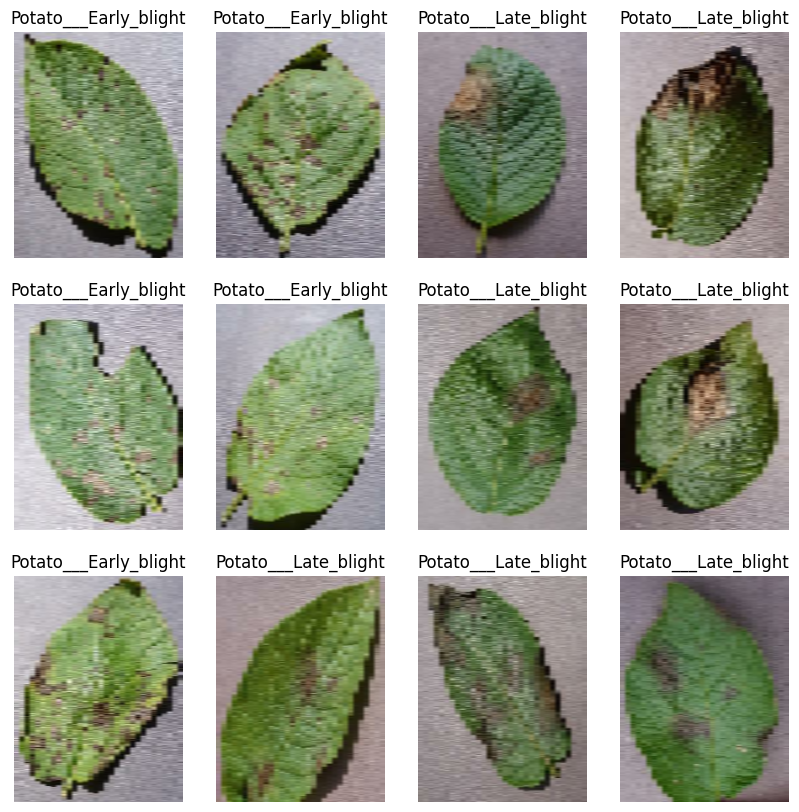

In [80]:
# display images
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset_potato.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"), aspect="auto")
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [81]:
# training specifications:
# 80% into training
# 20% splits into 10% validation and 10% test

train_size = 0.8
print(f"How many batches are 80% of dataset: {len(dataset_potato) * train_size}")

val_size = 0.1
print(f"How many batches are 10% of dataset: {len(dataset_potato) * val_size}")

train_dataset = dataset_potato.take(54) # exacly 54 batches are 80% of whole dataset_potato
to_be_split = dataset_potato.skip(54) # everything after 54 batches are test dataset
validation_dataset = to_be_split.take(6)
test_dataset = to_be_split.skip(6)

print(f"Splitting dataset: {len(train_dataset)}, {len(validation_dataset)}, {len(test_dataset)}")

How many batches are 80% of dataset: 54.400000000000006
How many batches are 10% of dataset: 6.800000000000001
Splitting dataset: 54, 6, 8


In [82]:
# function for splitting
def get_dataset_splitting_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

# now we can call function for splitting - for TF
train_dataset, validation_dataset, test_dataset = get_dataset_splitting_tf(dataset_potato)

print(f"Splitting dataset into -> training: {len(train_dataset)}, validation: {len(validation_dataset)}, test: {len(test_dataset)}")

Splitting dataset into -> training: 54, validation: 6, test: 8


In [83]:
# optimizing for training performance - faster training because batches are in RAM
# for traning dataset we will use caching
# because when we are training our model we keep that in RAM
# prepatch for performance if we are doing training with GPU
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [84]:
# applying preprocessing piplane - creating layers
# data augementation - applying filters to images, contrast, transformation -> generating new training samples
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [85]:
# building model - Convolutional Neural Network (CNN):

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

# let's see model summary:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_24 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_24 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (32, 60, 60, 64)        

In [86]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [87]:
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    validation_data=validation_dataset,
    verbose=1,
    epochs = 60,
)

Epoch 1/60
54/54 [==============================] - 23s 276ms/step - loss: 0.8978 - accuracy: 0.5029 - val_loss: 0.8180 - val_accuracy: 0.5156
Epoch 2/60
54/54 [==============================] - 3s 55ms/step - loss: 0.7965 - accuracy: 0.6215 - val_loss: 0.7096 - val_accuracy: 0.6302
Epoch 3/60
54/54 [==============================] - 3s 57ms/step - loss: 0.6815 - accuracy: 0.6869 - val_loss: 0.6475 - val_accuracy: 0.6615
Epoch 4/60
54/54 [==============================] - 4s 68ms/step - loss: 0.5449 - accuracy: 0.7836 - val_loss: 0.4510 - val_accuracy: 0.8438
Epoch 5/60
54/54 [==============================] - 3s 57ms/step - loss: 0.4865 - accuracy: 0.8038 - val_loss: 0.3023 - val_accuracy: 0.8958
Epoch 6/60
54/54 [==============================] - 3s 56ms/step - loss: 0.3711 - accuracy: 0.8507 - val_loss: 0.2316 - val_accuracy: 0.9375
Epoch 7/60
54/54 [==============================] - 4s 67ms/step - loss: 0.3055 - accuracy: 0.8900 - val_loss: 0.2335 - val_accuracy: 0.9219
Epoch 8/60


In [88]:
scores = model.evaluate(test_dataset)
scores

8/8 [==============================] - 6s 20ms/step - loss: 0.0783 - accuracy: 0.9688


[0.07831385731697083, 0.96875]

In [89]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

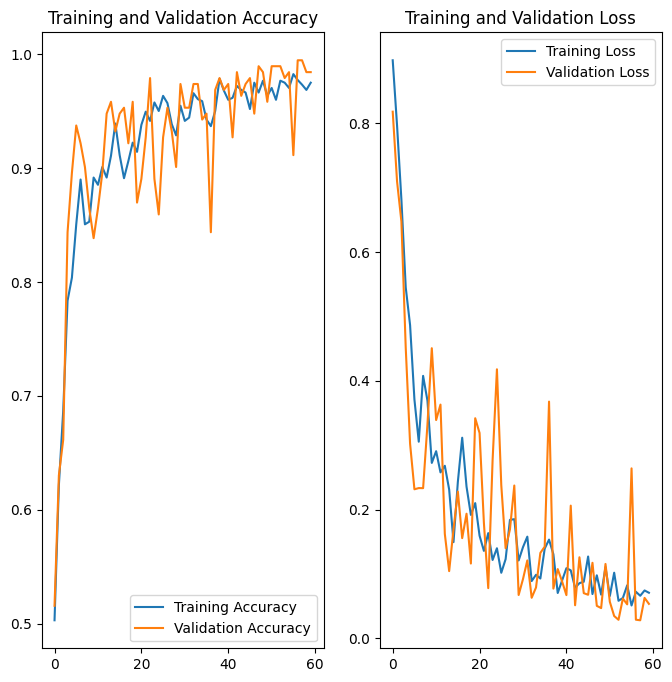

In [90]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Run prediction on a sample data (test_dataset)


first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 106ms/step
predicted label: Potato___Late_blight


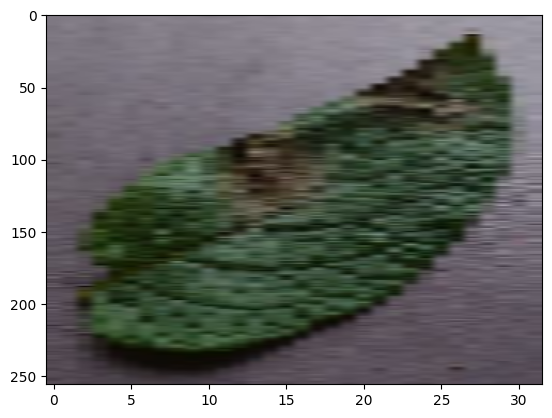

In [91]:
import numpy as np
for images_batch, labels_batch in test_dataset.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image, aspect="auto")
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# Funtion for inference

1/1 [==============================] - 0s 20ms/step


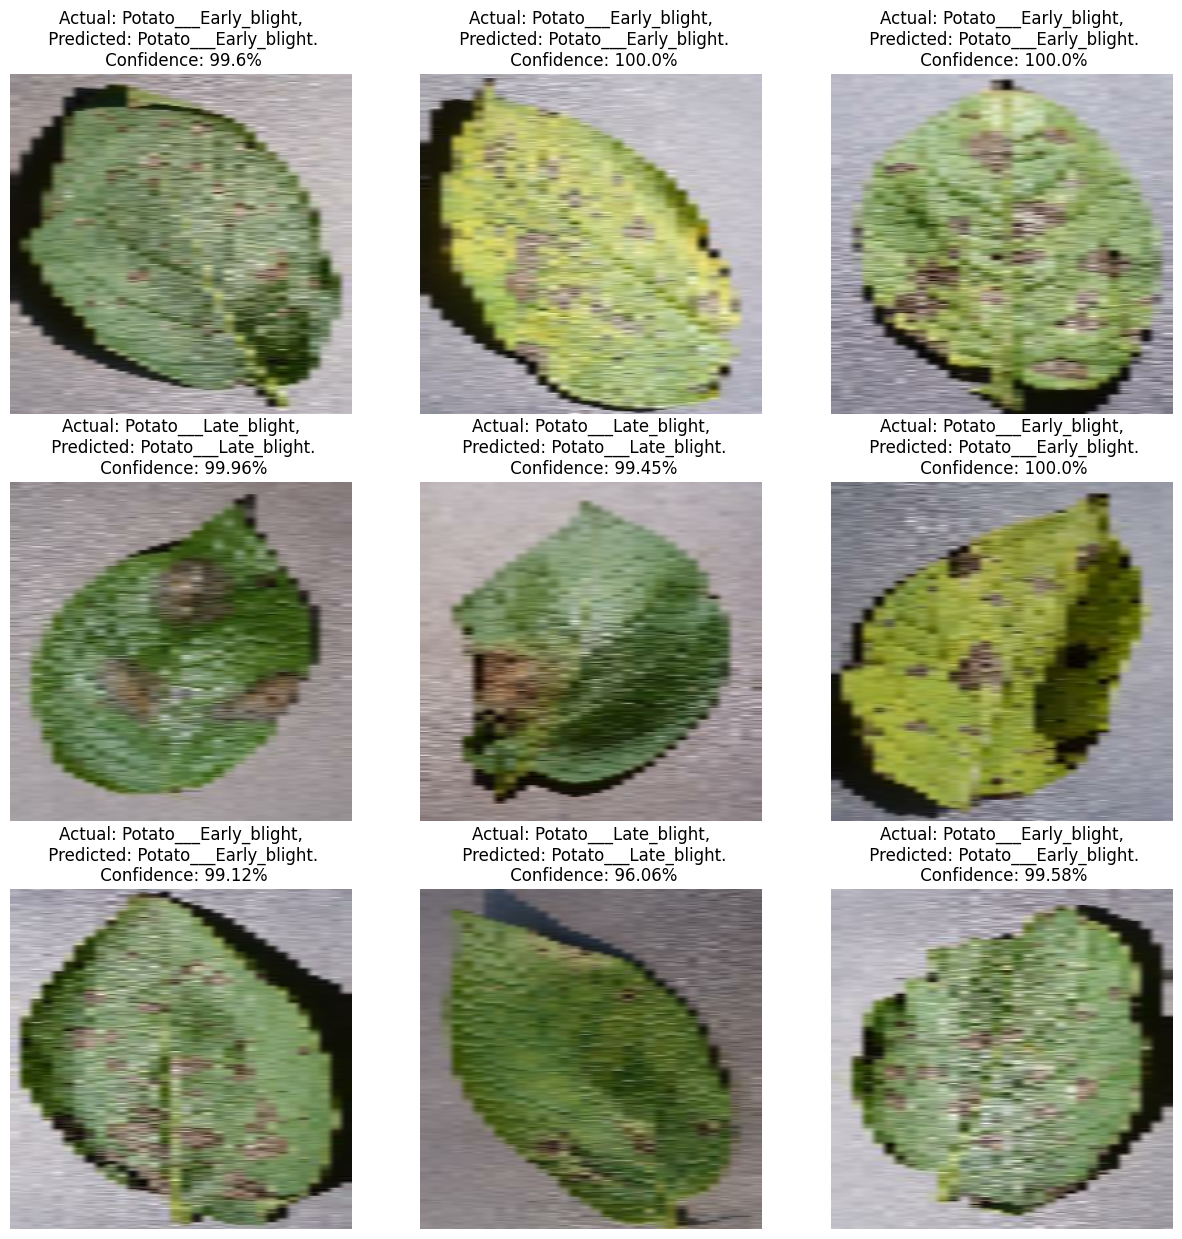

In [92]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), aspect="auto")

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [93]:
import os
import shutil

model_name = "potato_model"
plant = "potato"
model_version = 2

# Get the maximum version number for existing models
existing_versions = [int(i) for i in os.listdir(f"/gdrive/MyDrive/hackaton/saved_models/{plant}") if i.isdigit()]
#model_version = max(existing_versions, default=0) + 1

# Save the model
model.save(f"/gdrive/MyDrive/hackaton/saved_models/{plant}/v{model_version}_{model_name}")

# Zip the folder for easy download
folder_to_zip = f"/gdrive/MyDrive/hackaton/saved_models/{plant}/v{model_version}_{model_name}"
zip_file_path = f"/gdrive/MyDrive/hackaton/saved_models/{plant}/v{model_version}_{model_name}.zip"

shutil.make_archive(zip_file_path[:-4], 'zip', folder_to_zip)

'/gdrive/MyDrive/hackaton/saved_models/potato/v2_potato_model.zip'